# Importing All The Required Libraries


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import nltk, re, collections, pickle, os # nltk - Natural Language Toolkit
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# %matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)
plt.style.use('ggplot')
seed = 42

# Adding additional features

In [2]:
pd.set_option('styler.format.precision',3)
pd.options.display.float_format = '{:.3f}'.format

In [3]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'accuracy' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'accuracy' in s and 'val' in s]
    
    plt.figure(figsize = (12, 5), dpi = 100)
    COLOR = 'gray'
    
    plt.rc('legend', fontsize = 14)   # legend fontsize
    plt.rc('figure', titlesize = 12)  # fontsize of the figure title
        
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1, len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.subplot(1, 2, 1)
    plt.subplots_adjust(wspace = 2, hspace = 2)
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['axes.titlecolor'] = 'black'
    plt.rcParams['axes.labelcolor'] = COLOR
    plt.rcParams['xtick.color'] = COLOR
    plt.rcParams['ytick.color'] = COLOR
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b-o',
                 label = 'Train (' + str(str(format(history.history[l][-1],'.4f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g',
                 label = 'Valid (' + str(str(format(history.history[l][-1],'.4f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend(facecolor = 'gray', loc = 'best')
    plt.grid(True)
    plt.tight_layout()
    
    ## Accuracy
    plt.subplot(1, 2, 2)
    plt.subplots_adjust(wspace = 2, hspace = 2)
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['axes.titlecolor'] = 'black'
    plt.rcParams['axes.labelcolor'] = COLOR
    plt.rcParams['xtick.color'] = COLOR
    plt.rcParams['ytick.color'] = COLOR
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b-o',
                 label = 'Train (' + str(format(history.history[l][-1],'.4f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g',
                 label = 'Valid (' + str(format(history.history[l][-1],'.4f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(facecolor = 'gray', loc = 'best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_conf_matr(conf_matr, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.winter):
  """
  Citation
  ---------
  http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

  """  
  import itertools

  accuracy = np.trace(conf_matr) / np.sum(conf_matr).astype('float')
  sns.set(font_scale = 1.4)

  plt.figure(figsize = (12, 8))
  plt.imshow(conf_matr, interpolation = 'nearest', cmap = cmap)
  title = '\n' + title + '\n'
  plt.title(title)
  plt.colorbar()

  if classes is not None:
      tick_marks = np.arange(len(classes))
      plt.xticks(tick_marks, classes, rotation = 45)
      plt.yticks(tick_marks, classes)

  if normalize:
      conf_matr = conf_matr.astype('float') / conf_matr.sum(axis = 1)[:, np.newaxis]


  thresh = conf_matr.max() / 1.5 if normalize else conf_matr.max() / 2
  for i, j in itertools.product(range(conf_matr.shape[0]), range(conf_matr.shape[1])):
      if normalize:
          plt.text(j, i, "{:0.2f}%".format(conf_matr[i, j] * 100),
                    horizontalalignment = "center",
                    fontweight = 'bold',
                    color = "white" if conf_matr[i, j] > thresh else "black")
      else:
          plt.text(j, i, "{:,}".format(conf_matr[i, j]),
                    horizontalalignment = "center",
                    fontweight = 'bold',
                    color = "white" if conf_matr[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label\n\nAccuracy = {:0.2f}%; Error = {:0.2f}%'.format(accuracy * 100, (1 - accuracy) * 100))
  plt.show()


def plot_words(set, number):
  words_counter = collections.Counter([word for sentence in set for word in sentence.split()]) # finding words along with count
  most_counted = words_counter.most_common(number)
  most_count = pd.DataFrame(most_counted, columns = ["Words", "Amount"]).sort_values(by = "Amount") # sorted data frame
  most_count.plot.barh(x = "Words", 
                       y = "Amount",
                       color = "blue",
                       figsize = (10, 15))
  for i, v in enumerate(most_count["Amount"]):
    plt.text(v, i,
             " " + str(v),
             color = 'black',
             va = 'center',
             fontweight = 'bold')

def word_cloud(tag):
  df_words_nl = ' '.join(list(df_spam[df_spam['feature'] == tag]['message']))
  df_wc_nl = WordCloud(width = 600, height = 512).generate(df_words_nl)
  plt.figure(figsize = (13, 9), facecolor = 'k')
  plt.imshow(df_wc_nl)
  plt.axis('off')
  plt.tight_layout(pad = 1)
  plt.show()




# Reading and Preprocessing the dataset

In [4]:
df_spam = pd.read_csv('spam.csv', encoding = 'latin-1')

In [5]:
df_spam = df_spam.filter(['v1', 'v2'], axis = 1)
df_spam.columns = ['feature', 'message']
df_spam.drop_duplicates(inplace = True, ignore_index = True)
print('Number of null values:\n')
df_spam.isnull().sum()

Number of null values:



feature    0
message    0
dtype: int64

In [6]:
df_spam['feature'].value_counts()

feature
ham     4516
spam     653
Name: count, dtype: int64

In [7]:
df_spam.shape, df_spam.columns

((5169, 2), Index(['feature', 'message'], dtype='object'))

In [8]:
df_spam.describe()

,feature,message
count,5169,5169
unique,2,5169
top,ham,"Go until jurong point, crazy.. Available only ..."
freq,4516,1


In [9]:
df_spam['feature']

0        ham
1        ham
2       spam
3        ham
4        ham
        ... 
5164    spam
5165     ham
5166     ham
5167     ham
5168     ham
Name: feature, Length: 5169, dtype: object

In [10]:
ham_words = ''
spam_words = ''

In [11]:
# Creating a corpus of spam messages
for val in df_spam[df_spam['feature'] == 'spam']:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        spam_words = spam_words + words + ' '

# Creating a corpus of ham messages
for val in df_spam[df_spam['feature'] == 'ham']:
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        ham_words = ham_words + words + ' '

In [12]:
spam_wordcloud = WordCloud(width=500, height=300).generate(spam_words)
ham_wordcloud = WordCloud(width=500, height=300).generate(ham_words)

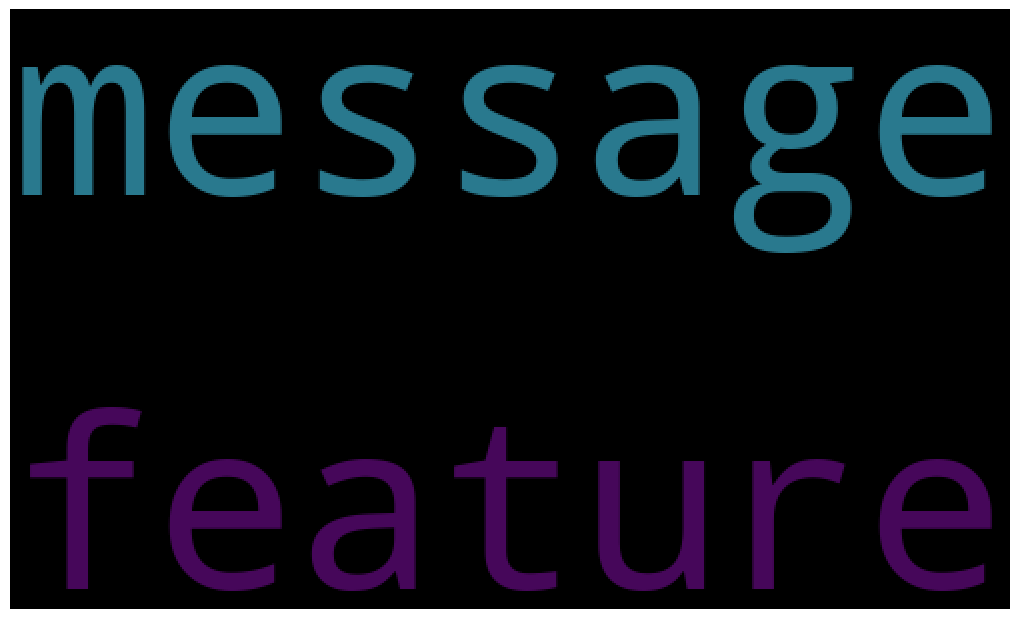

In [13]:
plt.figure( figsize=(10,8), facecolor='w')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

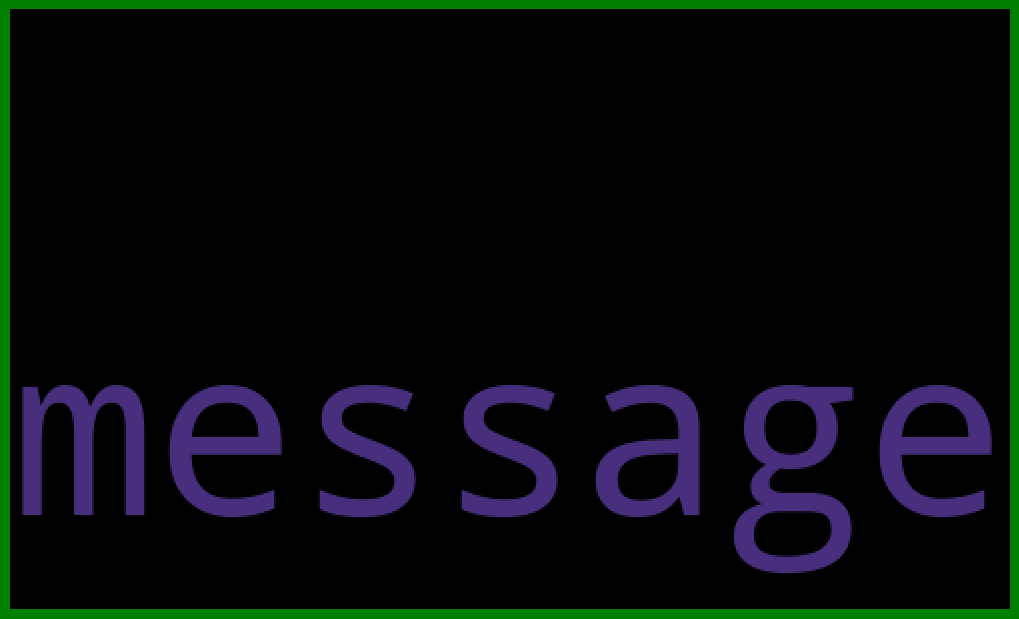

In [14]:
#Creating Ham wordcloud
plt.figure( figsize=(10,8), facecolor='g')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [16]:
df_spam['feature_class'] = df_spam.feature.map({'ham':0, 'spam':1})

In [17]:
df_spam.head()

,feature,message,feature_class
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


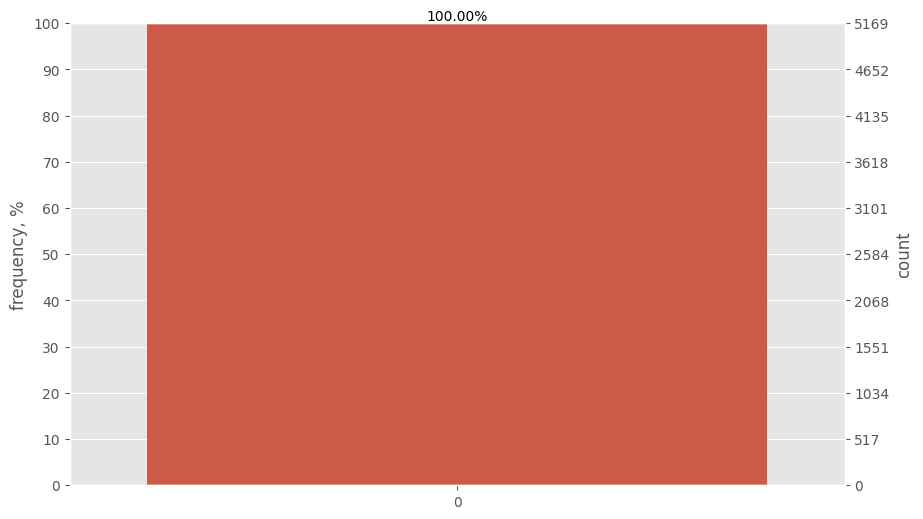

In [19]:
plt.figure(figsize = (10, 6))
counter = df_spam.shape[0]
ax1 = sns.countplot(df_spam['feature_class'])
ax2 = ax1.twinx()                      # Make double axis
ax2.yaxis.tick_left()                 # Switch so the counter's axis is on the right, frequency axis is on the left
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position('right')  # Also switch the labels over
ax2.yaxis.set_label_position('left')
ax2.set_ylabel('frequency, %')


for p in ax1.patches:
  x = p.get_bbox().get_points()[:, 0]
  y = p.get_bbox().get_points()[1, 1]
  ax1.annotate('{:.2f}%'.format(100. * y / counter),
              (x.mean(), y),
              ha = 'center',
              va = 'bottom')

# Use a LinearLocator to ensure the correct number of ticks
ax1.yaxis.set_major_locator(ticker.LinearLocator(11))

# Fix the frequency range to 0-100
ax2.set_ylim(0, 100)
ax1.set_ylim(0, counter)

# And use a MultipleLocator to ensure a tick spacing of 10
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

# Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
ax2.grid(None)

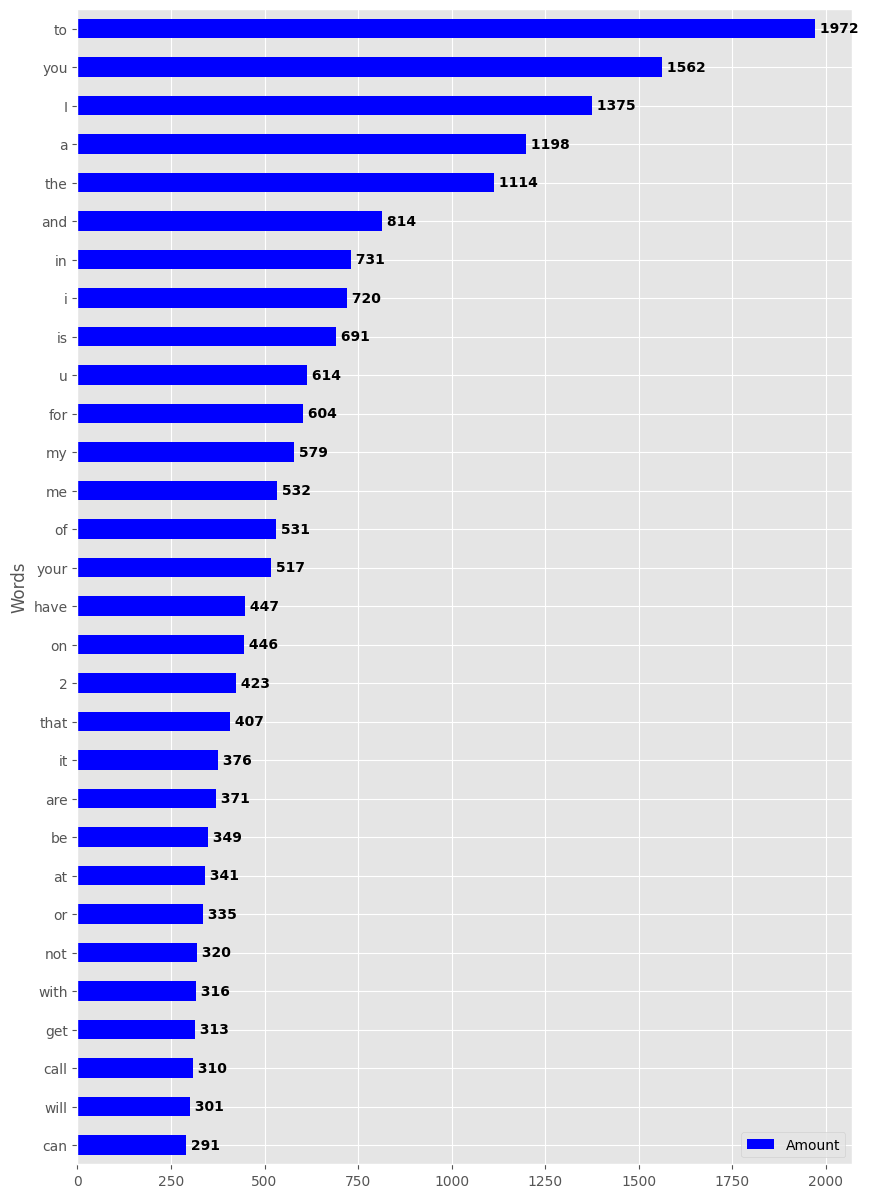

In [20]:
plot_words(df_spam['message'], number = 30)

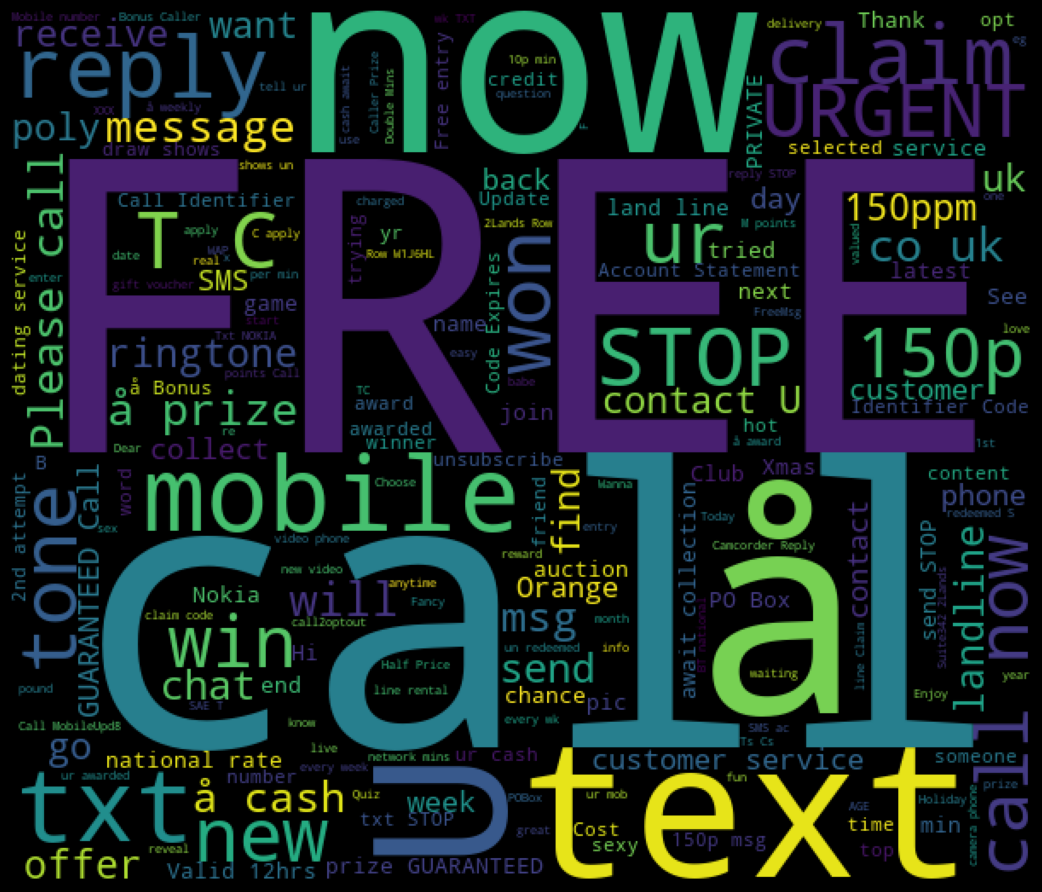

In [21]:
word_cloud('spam')

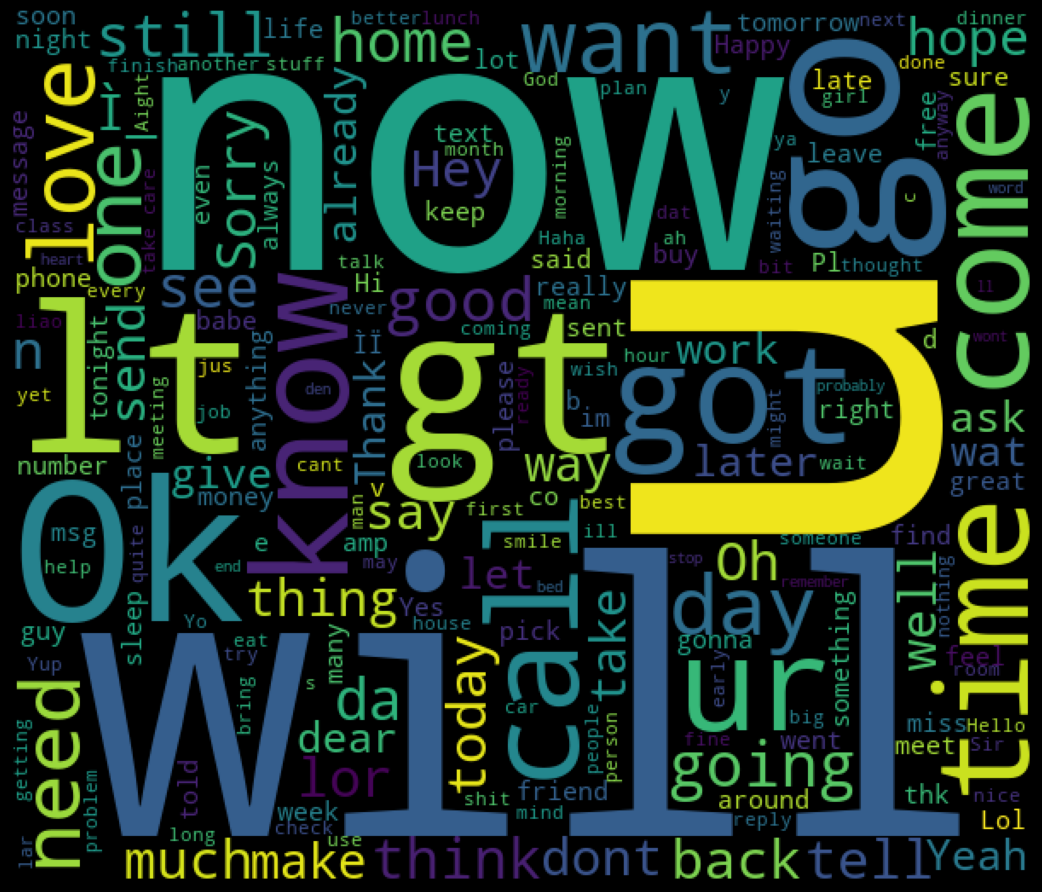

In [22]:
word_cloud('ham')

# USING ML FOR CLASSIFICATION

In [23]:
size_vocabulary = 500    # You can choose the size of vocabulary yourself in the range [500 .. 1500] (it should be divisible by 500)
embedding_dimension = 32  # You can choose the size of dimention yourself in the range [32 .. 256] (it should be divisible by 32)
trunc_type = 'post'
padding_type = 'post'
threshold = 0.5           # You can choose the size of threshold yourself in the range [0 .. 1]
oov_token = "<OOV>"
test_size, valid_size = 0.05, 0.2
num_epochs = 20           # You can choose the number of epochs yourself in the range [20 .. 50] (it should be divisible by 5)
drop_level = 0.3          # You can choose the size of drop level yourself in the range [0 .. 1]

In [24]:
print("\t\tStage I. Preliminary actions. Preparing of needed sets\n")
full_df_l = []
lemmatizer = WordNetLemmatizer()
for i in range(df_spam.shape[0]):
    mess_1 = df_spam.iloc[i, 1]
    mess_1 = re.sub('\b[\w\-.]+?@\w+?\.\w{2,4}\b', 'emailaddr', mess_1)
    mess_1 = re.sub('(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)', 'httpaddr', mess_1) 
    mess_1 = re.sub('£|\$', 'moneysymb', mess_1) 
    mess_1 = re.sub('\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b', 'phonenumbr', mess_1) 
    mess_1 = re.sub('\d+(\.\d+)?', 'numbr', mess_1) 
    mess_1 = re.sub('[^\w\d\s]', ' ', mess_1) 
    mess_1 = re.sub('[^A-Za-z]', ' ', mess_1).lower() 
    token_messages = word_tokenize(mess_1)
    mess = []
    for word in token_messages:
        if word not in set(stopwords.words('english')):
            mess.append(lemmatizer.lemmatize(word))
    txt_mess = " ".join(mess)
    full_df_l.append(txt_mess)

		Stage I. Preliminary actions. Preparing of needed sets



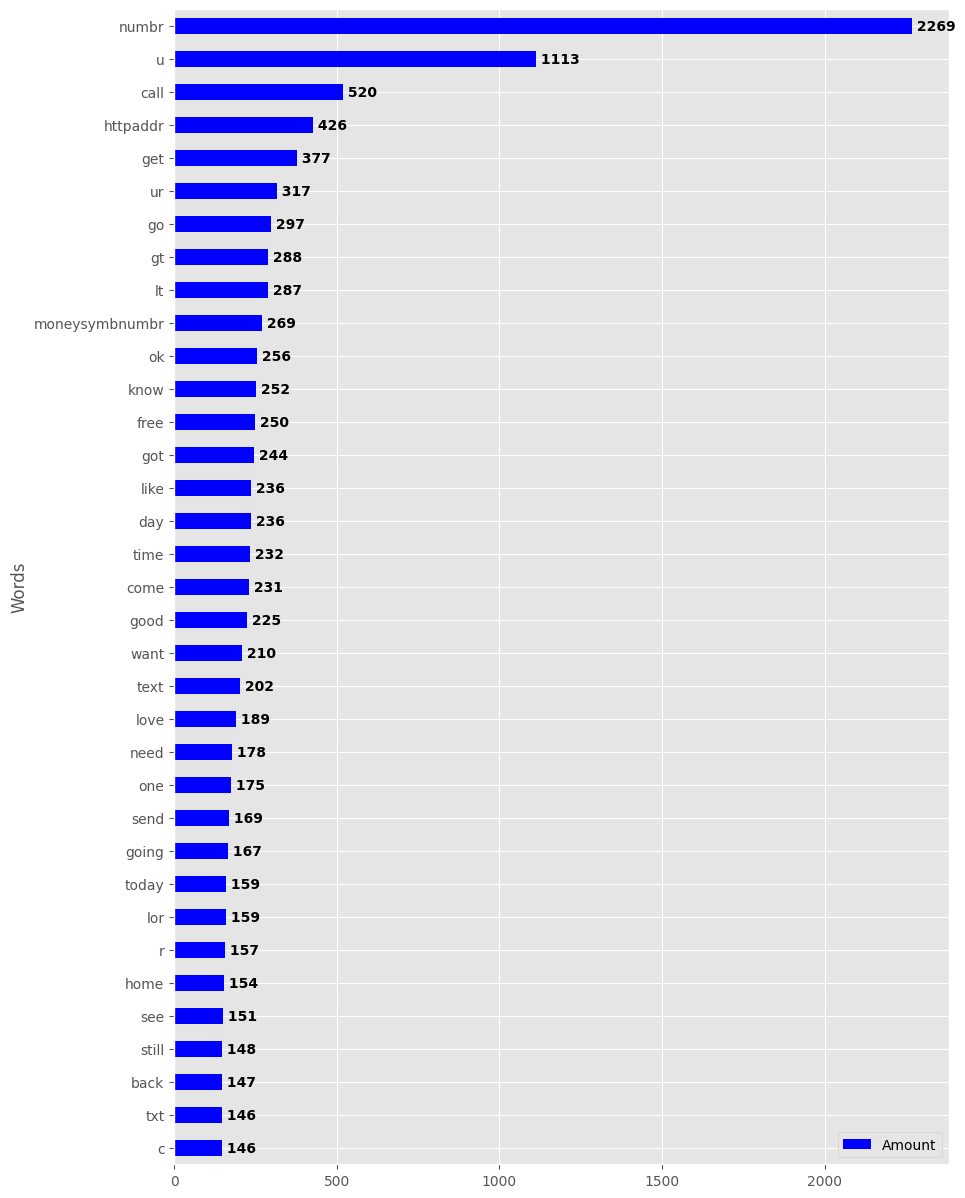

In [25]:
plot_words(full_df_l, number = 35)

In [26]:
add_df = CountVectorizer(max_features = size_vocabulary)
X = add_df.fit_transform(full_df_l).toarray()
y = df_spam.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = (test_size + valid_size), random_state = seed)
print('Number of rows in test set: ' + str(X_test.shape))
print('Number of rows in training set: ' + str(X_train.shape))

Number of rows in test set: (1293, 500)
Number of rows in training set: (3876, 500)


### USING NAIVE BAYES

		Stage IIa. Guassian Naive Bayes

The first two predicted labels: spam ham 

			Classification report:

               precision    recall  f1-score   support

         ham       0.99      0.63      0.77      1107
        spam       0.30      0.96      0.46       186

    accuracy                           0.68      1293
   macro avg       0.65      0.80      0.62      1293
weighted avg       0.89      0.68      0.73      1293
 



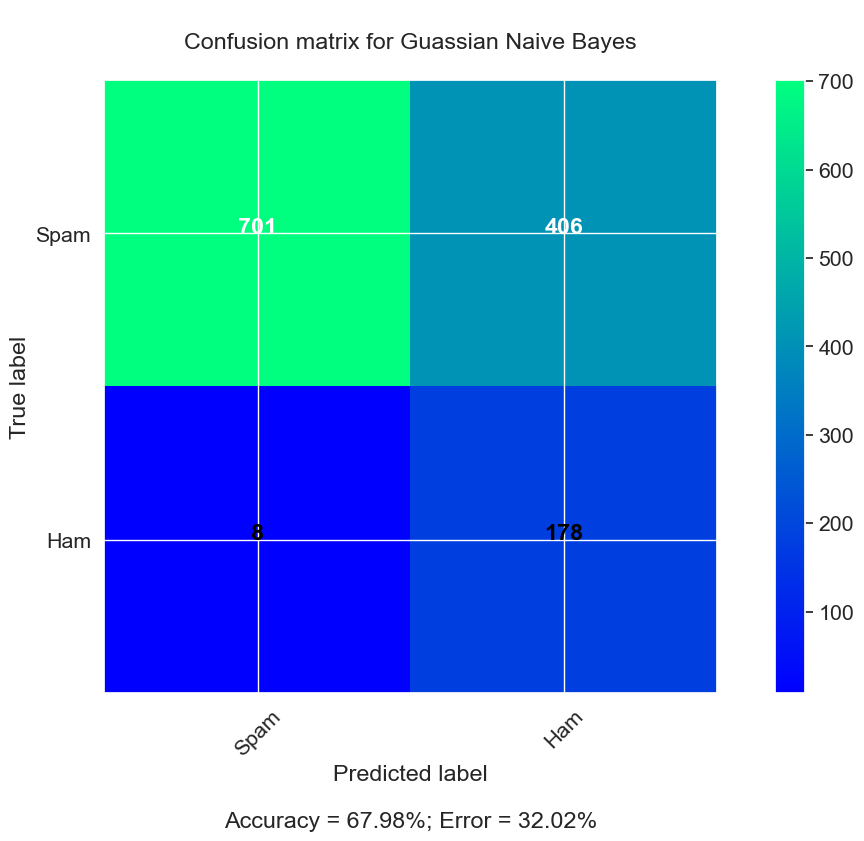

In [28]:
print("\t\tStage IIa. Guassian Naive Bayes\n")
class_NBC = GaussianNB().fit(X_train, y_train) # Guassian Naive Bayes
y_pred_NBC = class_NBC.predict(X_test)
print('The first two predicted labels:', y_pred_NBC[0],y_pred_NBC[1], '\n')
conf_m_NBC = confusion_matrix(y_test, y_pred_NBC)
class_rep_NBC = classification_report(y_test, y_pred_NBC)
print('\t\t\tClassification report:\n\n', class_rep_NBC, '\n')
plot_conf_matr(conf_m_NBC, classes = ['Spam','Ham'], normalize = False, title = 'Confusion matrix for Guassian Naive Bayes')

		Stage IIb. Multinomial Naive Bayes

The first two predicted labels: ham ham 

			Classification report:

               precision    recall  f1-score   support

         ham       0.98      0.98      0.98      1107
        spam       0.88      0.91      0.89       186

    accuracy                           0.97      1293
   macro avg       0.93      0.94      0.94      1293
weighted avg       0.97      0.97      0.97      1293
 



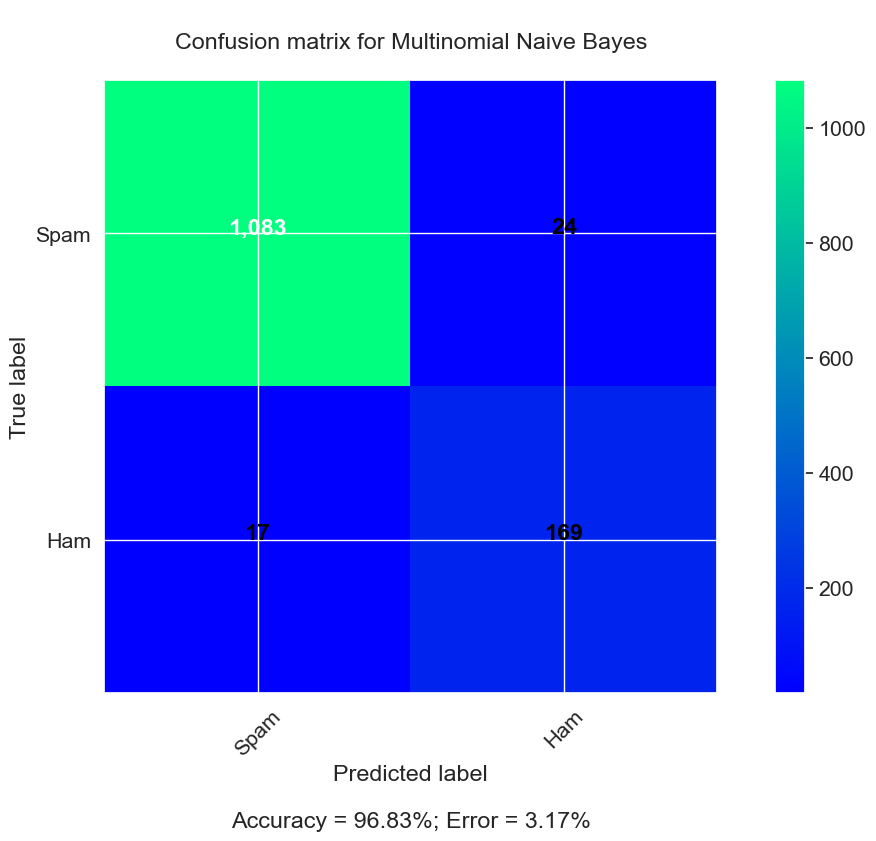

In [29]:
print("\t\tStage IIb. Multinomial Naive Bayes\n")
class_MNB = MultinomialNB().fit(X_train, y_train) # Multinomial Naive Bayes
y_pred_MNB = class_MNB.predict(X_test)
print('The first two predicted labels:', y_pred_MNB[0],y_pred_MNB[1], '\n')
conf_m_MNB = confusion_matrix(y_test, y_pred_MNB)
class_rep_MNB = classification_report(y_test, y_pred_MNB)
print('\t\t\tClassification report:\n\n', class_rep_MNB, '\n')
plot_conf_matr(conf_m_MNB, classes = ['Spam','Ham'], normalize = False, title = 'Confusion matrix for Multinomial Naive Bayes')

### USING DECISION TREE

		Stage III. Decision Tree Classifier

The first two predicted labels: ham ham 

			Classification report:

               precision    recall  f1-score   support

         ham       0.98      0.99      0.98      1107
        spam       0.93      0.87      0.89       186

    accuracy                           0.97      1293
   macro avg       0.95      0.93      0.94      1293
weighted avg       0.97      0.97      0.97      1293
 



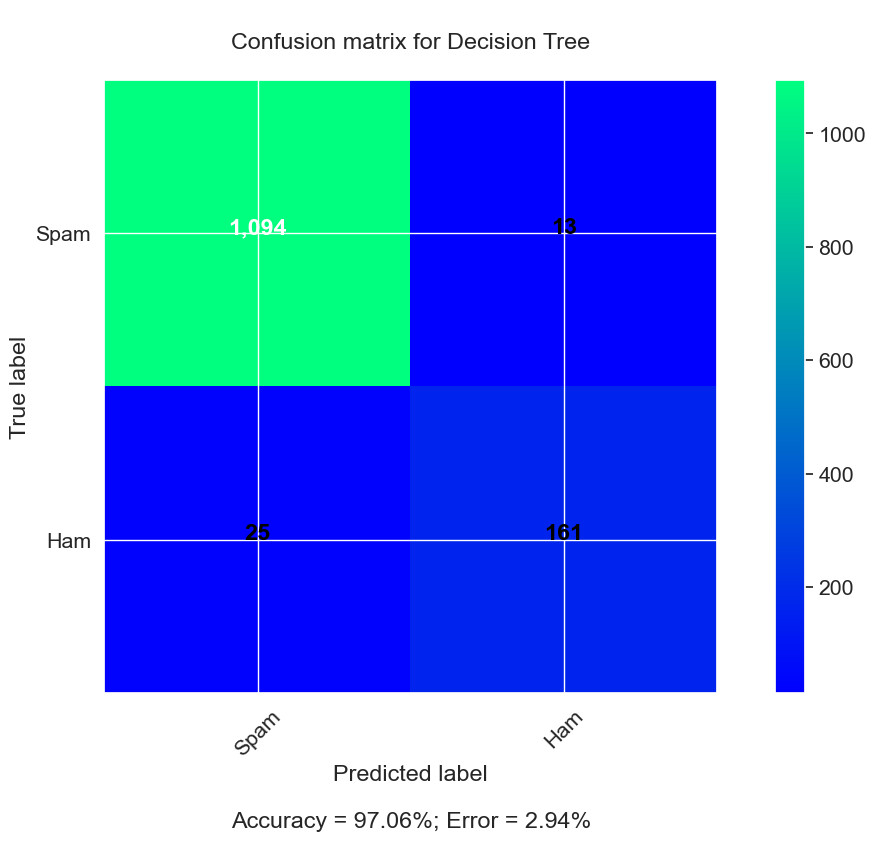

In [30]:
print("\t\tStage III. Decision Tree Classifier\n")
class_DTC = DecisionTreeClassifier(random_state = seed).fit(X_train, y_train)
y_pred_DTC = class_DTC.predict(X_test)
print('The first two predicted labels:', y_pred_DTC[0], y_pred_DTC[1], '\n')
conf_m_DTC = confusion_matrix(y_test, y_pred_DTC)
class_rep_DTC = classification_report(y_test, y_pred_DTC)
print('\t\t\tClassification report:\n\n', class_rep_DTC, '\n')
plot_conf_matr(conf_m_DTC, classes = ['Spam','Ham'], normalize = False, title = 'Confusion matrix for Decision Tree')

### USING LOGISTIC REGRESSION

		Stage IV. Logistic Regression

The first two predicted labels: ham ham 

			Classification report:

               precision    recall  f1-score   support

         ham       0.98      0.99      0.99      1107
        spam       0.96      0.85      0.91       186

    accuracy                           0.97      1293
   macro avg       0.97      0.92      0.95      1293
weighted avg       0.97      0.97      0.97      1293
 



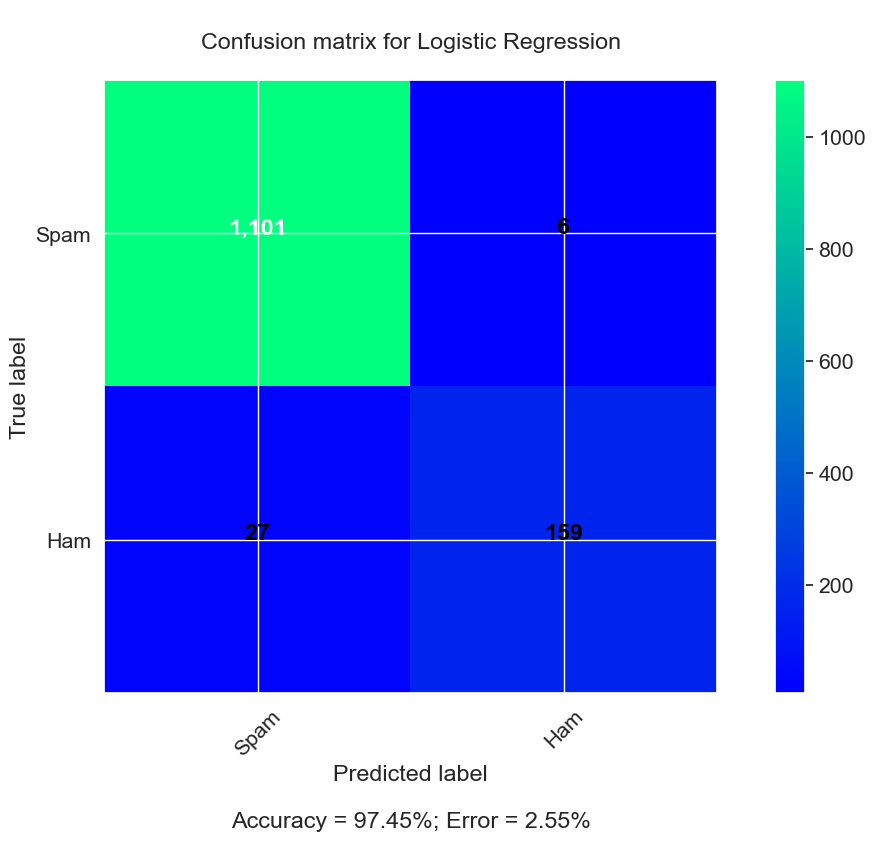

In [31]:
print("\t\tStage IV. Logistic Regression\n")
class_LR = LogisticRegression(random_state = seed, solver = 'liblinear').fit(X_train, y_train)
y_pred_LR = class_LR.predict(X_test)
print('The first two predicted labels:', y_pred_LR[0], y_pred_LR[1], '\n')
conf_m_LR = confusion_matrix(y_test, y_pred_LR)
class_rep_LR = classification_report(y_test, y_pred_LR)
print('\t\t\tClassification report:\n\n', class_rep_LR, '\n')
plot_conf_matr(conf_m_LR, classes = ['Spam','Ham'], normalize = False, title = 'Confusion matrix for Logistic Regression')

### USING KNN

		Stage V. KNeighbors Classifier

The firs two predicted labels: ham ham 

			Classification report:

               precision    recall  f1-score   support

         ham       0.95      0.99      0.97      1107
        spam       0.96      0.69      0.80       186

    accuracy                           0.95      1293
   macro avg       0.95      0.84      0.89      1293
weighted avg       0.95      0.95      0.95      1293
 



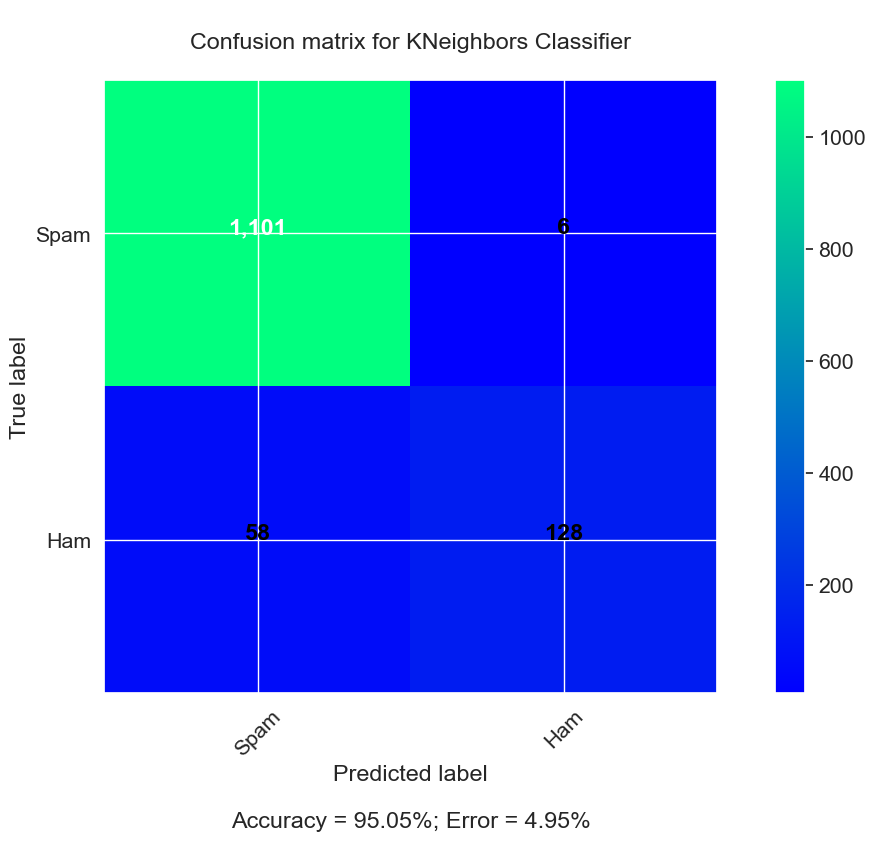

In [32]:
print("\t\tStage V. KNeighbors Classifier\n")
class_KNC = KNeighborsClassifier(n_neighbors = 3).fit(X_train, y_train)
y_pred_KNC = class_KNC.predict(X_test)
print('The firs two predicted labels:', y_pred_KNC[0], y_pred_KNC[1], '\n')
conf_m_KNC = confusion_matrix(y_test, y_pred_KNC)
class_rep_KNC = classification_report(y_test, y_pred_KNC)
print('\t\t\tClassification report:\n\n', class_rep_KNC, '\n')
plot_conf_matr(conf_m_KNC, classes = ['Spam','Ham'], normalize = False, title = 'Confusion matrix for KNeighbors Classifier')

### USING SVC

		Stage VI. Support Vector Classification

The first two predicted labels: ham ham 

			Classification report:

               precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1107
        spam       0.97      0.85      0.91       186

    accuracy                           0.98      1293
   macro avg       0.97      0.93      0.95      1293
weighted avg       0.98      0.98      0.97      1293
 



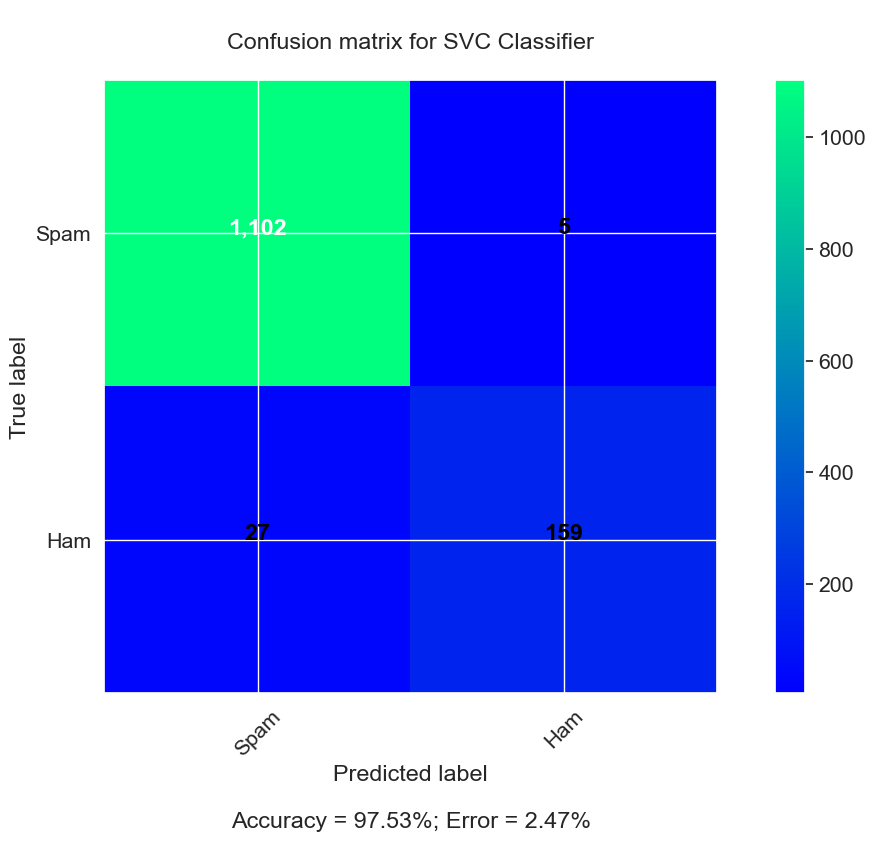

In [33]:
print("\t\tStage VI. Support Vector Classification\n")
class_SVC = SVC(probability = True, random_state = seed).fit(X_train, y_train)
y_pred_SVC = class_SVC.predict(X_test)
print('The first two predicted labels:', y_pred_SVC[0], y_pred_SVC[1], '\n')
conf_m_SVC = confusion_matrix(y_test, y_pred_SVC)
class_rep_SVC = classification_report(y_test, y_pred_SVC)
print('\t\t\tClassification report:\n\n', class_rep_SVC, '\n')
plot_conf_matr(conf_m_SVC, classes = ['Spam','Ham'], normalize = False, title = 'Confusion matrix for SVC Classifier')

### USING GRADIENT BOOSTING

		Stage VII. Gradient Boosting Classifier

The first two predicted labels: ham ham 

			Classification report:

               precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1107
        spam       0.97      0.85      0.91       186

    accuracy                           0.98      1293
   macro avg       0.97      0.93      0.95      1293
weighted avg       0.98      0.98      0.97      1293
 



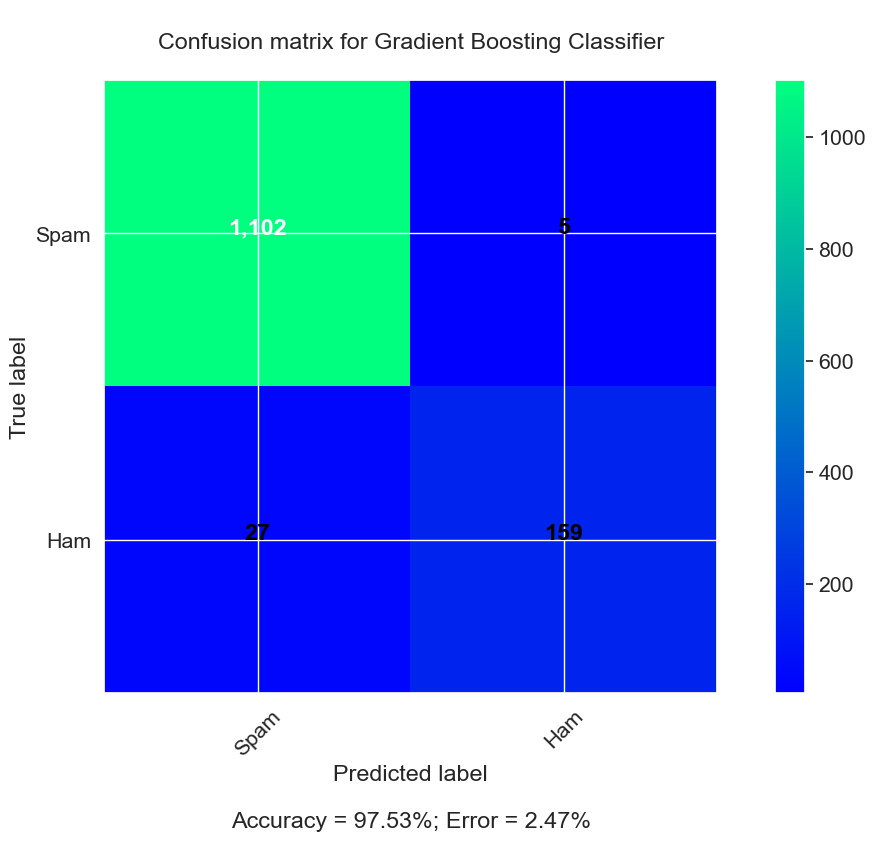

In [34]:
print("\t\tStage VII. Gradient Boosting Classifier\n")
class_GBC = GradientBoostingClassifier(random_state = seed).fit(X_train, y_train)
y_pred_GBC = class_GBC.predict(X_test)
print('The first two predicted labels:', y_pred_GBC[0], y_pred_GBC[1], '\n')
conf_m_GBC = confusion_matrix(y_test, y_pred_GBC)
class_rep_GBC = classification_report(y_test, y_pred_GBC)
print('\t\t\tClassification report:\n\n', class_rep_GBC, '\n')
plot_conf_matr(conf_m_GBC, classes = ['Spam','Ham'], normalize = False, title = 'Confusion matrix for Gradient Boosting Classifier')

### USING BAGGING CLASSIFIER

		Stage VIII. Bagging Classifier + SVC

The first two predicted labels: ham ham 

			Classification report:

               precision    recall  f1-score   support

         ham       0.98      0.99      0.99      1107
        spam       0.96      0.87      0.91       186

    accuracy                           0.98      1293
   macro avg       0.97      0.93      0.95      1293
weighted avg       0.98      0.98      0.98      1293
 



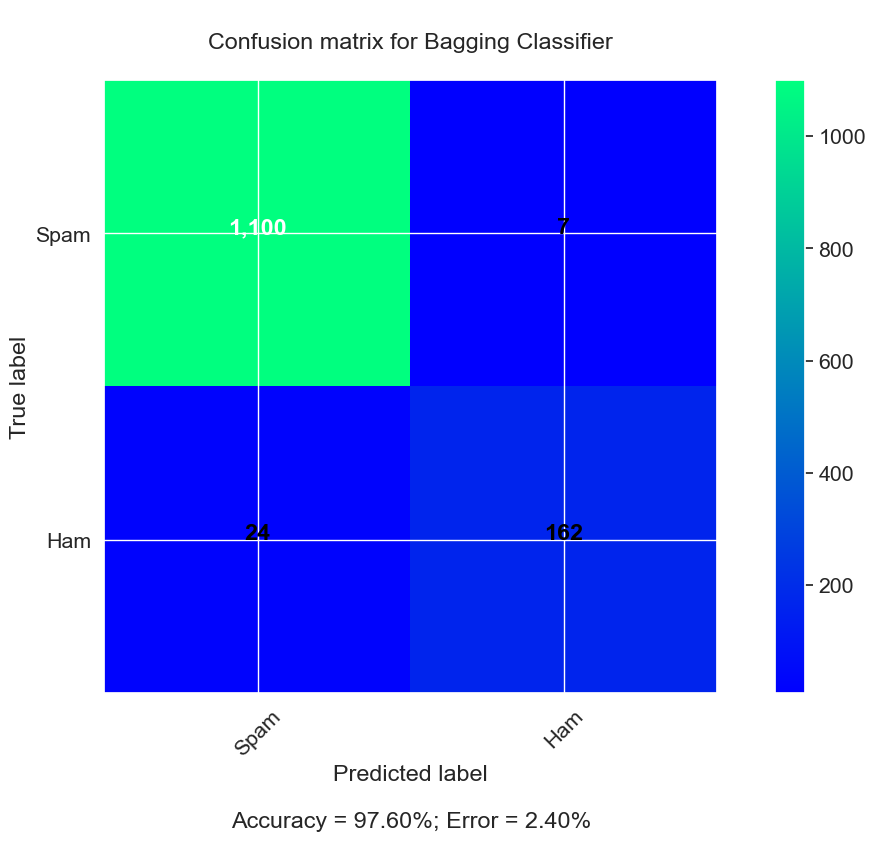

In [37]:
print("\t\tStage VIII. Bagging Classifier + SVC\n")
class_BC = BaggingClassifier(class_SVC).fit(X_train, y_train)
y_pred_BC = class_BC.predict(X_test)
print('The first two predicted labels:', y_pred_BC[0], y_pred_BC[1], '\n')
conf_m_BC = confusion_matrix(y_test, y_pred_BC)
class_rep_BC = classification_report(y_test, y_pred_BC)
print('\t\t\tClassification report:\n\n', class_rep_BC, '\n')
plot_conf_matr(conf_m_BC, classes = ['Spam','Ham'], normalize = False, title = 'Confusion matrix for Bagging Classifier')

# USING DEEP LEARNING FOR ADVANCED CLASSIFICATION

### 1. Preparing The Datasets

In [38]:
print("Stage I. Preliminary actions. Preparing of needed sets\n")

sentences_new_set = []
labels_new_set = []
for i in range(0, df_spam.shape[0], 1):
    sentences_new_set.append(df_spam['message'][i])
    labels_new_set.append(df_spam['feature'][i])

Stage I. Preliminary actions. Preparing of needed sets



In [39]:
train_size = int(df_spam.shape[0] * (1 - test_size - valid_size))
valid_bound = int(df_spam.shape[0] * (1 - valid_size))

train_sentences = sentences_new_set[0 : train_size]
valid_sentences = sentences_new_set[train_size : valid_bound]
test_sentences = sentences_new_set[valid_bound : ]

train_labels_str = labels_new_set[0 : train_size]
valid_labels_str = labels_new_set[train_size : valid_bound]
test_labels_str = labels_new_set[valid_bound : ]

### 2. Label Transformation 

In [41]:
print("Stage II. Labels transformations\n")

train_labels = [0] * len(train_labels_str)
for ind, item in enumerate(train_labels_str):
    if item == 'ham':
        train_labels[ind] = 1
    else:
        train_labels[ind] = 0
        
valid_labels = [0] * len(valid_labels_str)
for ind, item in enumerate(valid_labels_str):
    if item == 'ham':
        valid_labels[ind] = 1
    else:
        valid_labels[ind] = 0

test_labels = [0] * len(test_labels_str)
for ind, item in enumerate(test_labels_str):
    if item == 'ham':
        test_labels[ind] = 1
    else:
        test_labels[ind] = 0

train_labels = np.array(train_labels)
valid_labels = np.array(valid_labels)
test_labels = np.array(test_labels)

Stage II. Labels transformations



### 3. Tokenization

In [42]:
print("Stage III. Tokenization\n")

tokenizer = Tokenizer(num_words = size_vocabulary,
                      oov_token = oov_token,
                      lower = False)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

Stage III. Tokenization



In [43]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
size_voc = len(word_index) + 1
max_len = max([len(i) for i in train_sequences])
train_set = pad_sequences(train_sequences,
                                padding = padding_type,
                                maxlen = max_len,
                                truncating = trunc_type) 

valid_sequences = tokenizer.texts_to_sequences(valid_sentences)
valid_set = pad_sequences(valid_sequences,
                               padding = padding_type,
                               maxlen = max_len,
                               truncating = trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_set = pad_sequences(test_sequences,
                               padding = padding_type,
                               maxlen = max_len,
                               truncating = trunc_type)

### 4. Model Building

In [44]:
print("Stage IV. Model building\n")

model = Sequential([
    Embedding(size_voc, embedding_dimension, input_length = max_len),
    Bidirectional(LSTM(100)),
    Dropout(drop_level),
    Dense(20, activation = 'relu'),
    Dropout(drop_level),
    Dense(1, activation = 'sigmoid')
])

Stage IV. Model building



### 5. Model Fitting

In [48]:
print("Stage V. Model compiling & fitting\n")
optim = Adam(learning_rate = 0.0001)

model.compile(loss = 'binary_crossentropy',
              optimizer = optim,
              metrics = ['accuracy'])
model.summary()

Stage V. Model compiling & fitting

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 189, 32)           303040    
                                                                 
 bidirectional (Bidirection  (None, 200)               106400    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 20)                4020      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                    

In [46]:
history = model.fit(train_set, 
                    train_labels,
                    epochs = num_epochs, 
                    validation_data = (valid_set, valid_labels),
                    workers = os.cpu_count(),
                    use_multiprocessing = True,
                    verbose = 1)

Epoch 1/20
122/122 [==============================] - 22s 139ms/step - loss: 0.5069 - accuracy: 0.8674 - val_loss: 0.3507 - val_accuracy: 0.8803
Epoch 2/20
122/122 [==============================] - 17s 137ms/step - loss: 0.3083 - accuracy: 0.8695 - val_loss: 0.2705 - val_accuracy: 0.8803
Epoch 3/20
122/122 [==============================] - 21s 175ms/step - loss: 0.2468 - accuracy: 0.8860 - val_loss: 0.2412 - val_accuracy: 0.9035
Epoch 4/20
122/122 [==============================] - 24s 197ms/step - loss: 0.2087 - accuracy: 0.9247 - val_loss: 0.2088 - val_accuracy: 0.9228
Epoch 5/20
122/122 [==============================] - 24s 199ms/step - loss: 0.1726 - accuracy: 0.9512 - val_loss: 0.1833 - val_accuracy: 0.9305
Epoch 6/20
122/122 [==============================] - 24s 194ms/step - loss: 0.1419 - accuracy: 0.9585 - val_loss: 0.1790 - val_accuracy: 0.9305
Epoch 7/20
122/122 [==============================] - 23s 185ms/step - loss: 0.1184 - accuracy: 0.9667 - val_loss: 0.1375 - val_ac

### 6. Visualization

Stage VI. Results visualization



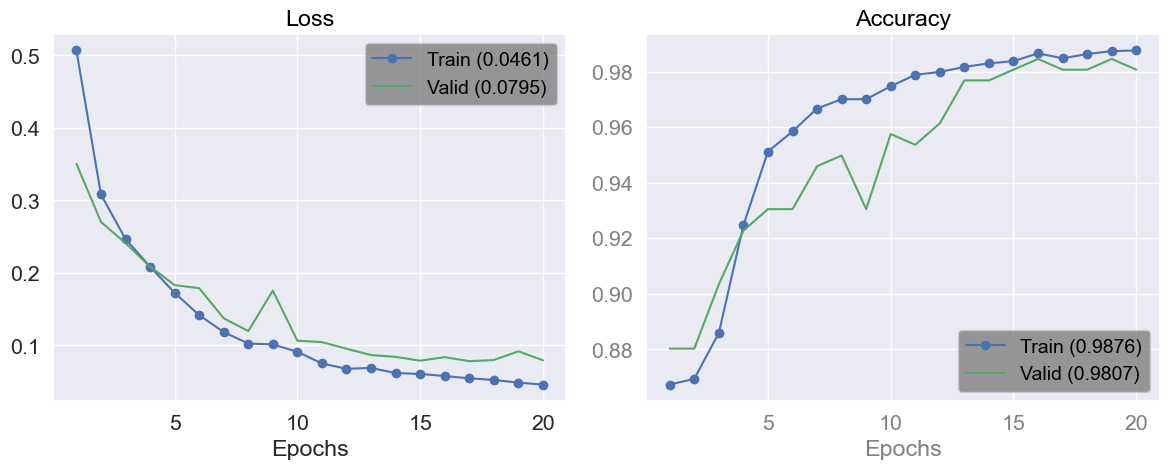

In [49]:
print("Stage VI. Results visualization\n")
plot_history(history)

### 7. Prediction Check

In [50]:
M_name = "My_model"
pickle.dump(tokenizer, open(M_name + ".pkl", "wb"))
filepath = M_name + '.h5'
tf.keras.models.save_model(model, filepath, include_optimizer = True, save_format = 'h5', overwrite = True)
print("Size of the saved model :", os.stat(filepath).st_size, "bytes")

Size of the saved model : 1685720 bytes


C:\Users\varig\AppData\Local\Temp\ipykernel_28120\5123735.py:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, filepath, include_optimizer = True, save_format = 'h5', overwrite = True)


33/33 [==============================] - 2s 28ms/step
			Classification report:

               precision    recall  f1-score   support

           0       0.92      0.88      0.90       117
           1       0.98      0.99      0.99       917

    accuracy                           0.98      1034
   macro avg       0.95      0.94      0.94      1034
weighted avg       0.98      0.98      0.98      1034
 



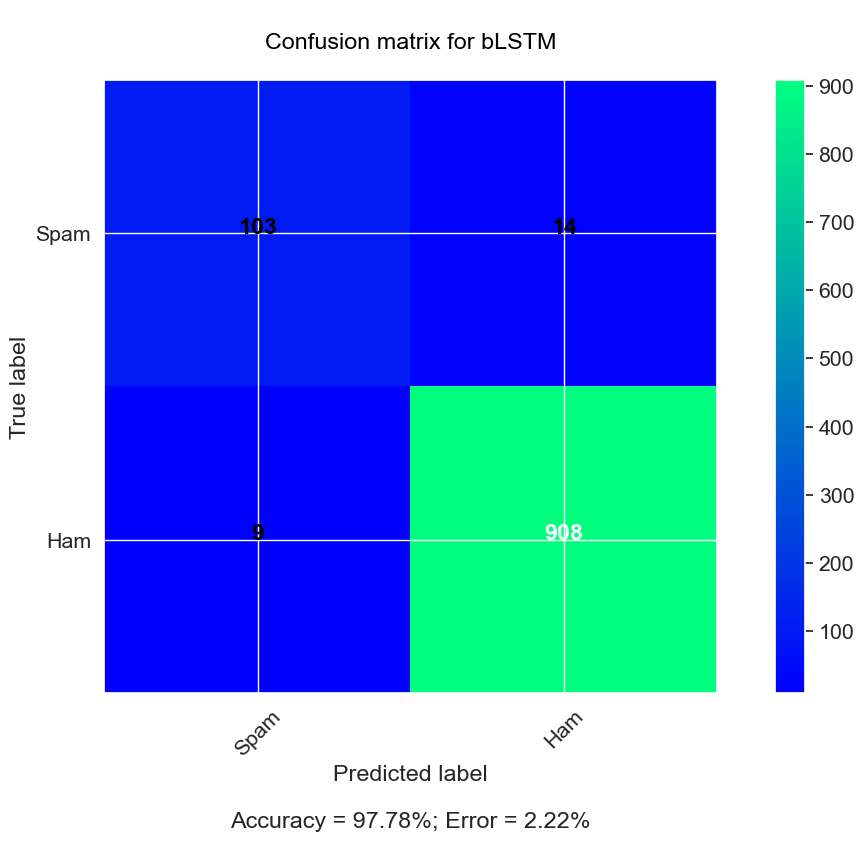

In [51]:
y_pred_bLSTM = model.predict(test_set)

y_prediction = [0] * y_pred_bLSTM.shape[0]
for ind, item in enumerate(y_pred_bLSTM):
    if item > threshold:
        y_prediction[ind] = 1
    else:
        y_prediction[ind] = 0

conf_m_bLSTM = confusion_matrix(test_labels, y_prediction)
class_rep_bLSTM = classification_report(test_labels, y_prediction)
print('\t\t\tClassification report:\n\n', class_rep_bLSTM, '\n')
plot_conf_matr(conf_m_bLSTM, classes = ['Spam','Ham'], normalize = False, title = 'Confusion matrix for bLSTM')

In [52]:
# You can change this message (as any short sentence) yourself
message_example = ["Darling, please give me a cup of tea"] 

message_example_tp = pad_sequences(tokenizer.texts_to_sequences(message_example),
                                   maxlen = max_len,
                                   padding = padding_type,
                                   truncating = trunc_type)

pred = float(model.predict(message_example_tp))
if (pred > threshold):
    print ("This message is a real text")
else:
    print("This message is a spam message")

1/1 [==============================] - 0s 35ms/step
This message is a real text
